In [1]:
from numpy import asarray
from skimage import data, io, color, filters
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Q1

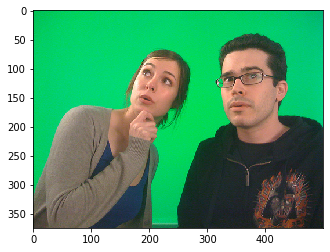

In [2]:
actors = io.imread("../assets/assignment-1/greenscreen.jpg")
plt.imshow(actors)

### Get threshold image

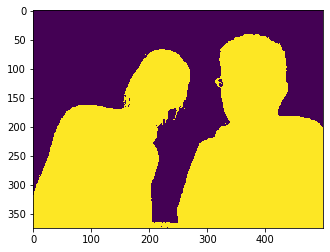

In [3]:
def threshold_func(image):
    r, g, b = image[:,:,0], image[:,:,1], image[:,:,2]
    return np.array(np.logical_or(r >= 10, g <= 100, b <= 50), dtype="uint8") # DeMorgan's law : A and B and C = not A or not B or not C
outline = threshold_func(actors)
plt.imshow(outline)

### Isolate actors and impose on a new background.

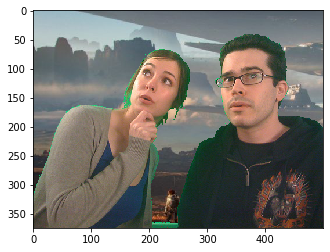

In [4]:
background = io.imread("../assets/assignment-1/background.jpg")
output = np.zeros(np.shape(actors), dtype="uint8")
w, h, _ = np.shape(actors)
for i in range(w):
    for k in range(h):
        if outline[i][k]:
            output[i][k] = actors[i][k]
        else:
            output[i][k] = background[i][k]
plt.imshow(output)

# Q2

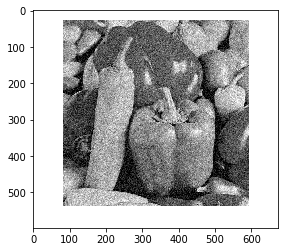

In [5]:
noisy  = io.imread("../assets/assignment-1/noisy.png")
plt.imshow(noisy)

In [6]:
def float2uint8(matrix):
    shape = np.shape(matrix)
    new_matrix = np.zeros(shape, dtype="uint8")
    w, h = shape[0], shape[1]
    for i in range(w):
        for k in range(h):
            new_matrix[i][k] = matrix[i][k]
    return new_matrix

In [7]:
def rgb2grayscale(image):
    w, h, _ = np.shape(image)
    output = np.zeros((w,h), dtype="float")
    for i in range(w):
        for j in range(h):
            r, g, b = image[i][j][0], image[i][j][1], image[i][j][2]
            output[i][j] = 0.2125*r + 0.7154*g + 0.0721*b
    return output.astype(np.uint8)

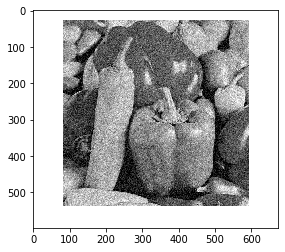

In [8]:
grayscale = rgb2grayscale(noisy)
plt.imshow(grayscale, cmap=plt.cm.gray)

In [9]:
within_bounds = lambda points, bounds: 0 < points[0] < bounds[0] and 0 < points[1] < bounds[1]

In [20]:
def apply_averaging_mask(A, h):
    shapeA = np.shape(A)
    M = 1/h**2 * np.ones((h, h), dtype="float")
    output = np.zeros(shapeA, dtype="float")
    row_m, col_m = np.shape(M)
    row_a, col_a, = shapeA[0], shapeA[1]
    for r in range(row_a):
        for c in range(col_a):
            val = 0.0
            for i in range(-h, h+1):
                for j in range(-h, h+1):
                    if within_bounds((i+h+1, j+h+1), (row_m, col_m)) and within_bounds((r+i, c+j), (row_a, col_a)):
                        val += M[i+h+1][j+h+1] * A[r+i][c+j]
            output[r][c] = val
    return output.astype(np.uint8)

def apply_median_filter(A, h):
    shapeA = np.shape(A)
    M = np.zeros(h*h, dtype="float")
    output = np.zeros(shapeA, dtype="float")
    row_m, col_m = h, h
    row_a, col_a, = shapeA[0], shapeA[1]
    hrow_m, hcol_m = row_m // 2, col_m //2
    
    for r in range(hrow_m,  row_a - hrow_m):
        for c in range(hcol_m, col_a - hcol_m):
            i = 0
            for fx in range(0, row_m):
                for fy in range(0, col_m):
                    M[i] = A[r + fx - hrow_m][c + fy - hcol_m]
                    i += 1
            M.sort()
            output[r][c] = M[len(M)//2]
    return output.astype(np.uint8)

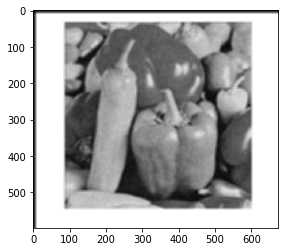

In [14]:
h = 10
avg_filter = apply_averaging_mask(grayscale , h)
plt.imshow(avg_filter, cmap=plt.cm.gray)

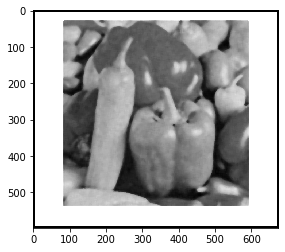

In [26]:
h = 10
median_filter = apply_median_filter(grayscale , h)
plt.imshow(median_filter, cmap=plt.cm.gray)

In [30]:
unsharp_filter = np.zeros(np.shape(median_filter), dtype="float")
r, c = np.shape(median_filter)
min_val, max_val = 0, 0
for i in range(r):
    for j in range(c):
        unsharp_filter[i][j] = 2 * grayscale[i][j] - median_filter[i][j] 
        if min_val > unsharp_filter[i][j]:
            min_val = unsharp_filter[i][j]
        if max_val < unsharp_filter[i][j]:
            max_val = unsharp_filter[i][j]

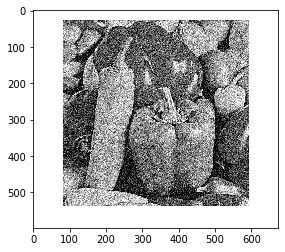

In [37]:
unsharp = float2uint8(np.clip(unsharp_filter, 0, 255))
plt.imshow(unsharp, cmap=plt.cm.gray)

In [49]:
def normalize_intensities(image, min_val, max_val):
    w, h = np.shape(image)
    output = np.zeros((w,h), dtype="float")
    fac = 255 / (max_val - min_val)
    for i in range(w):
        for j in range(h):
            output[i][j] = fac * (image[i][j] - min_val)
    return output.astype(np.uint8)

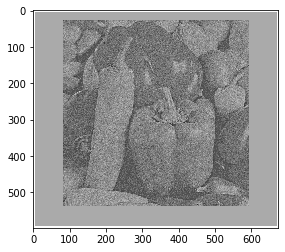

In [51]:
scaled = normalize_intensities(unsharp_filter, min_val, max_val)
plt.imshow(scaled, cmap=plt.cm.gray)

# Q3

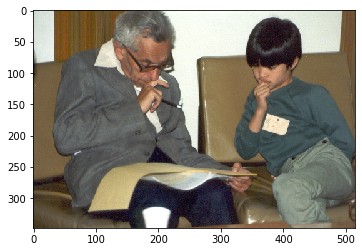

In [56]:
erdos_with_tao = io.imread("../assets/assignment-1/erdos_with_tao.jpg")
plt.imshow(erdos_with_tao, cmap=plt.cm.gray)

In [102]:
def nn_scale_image(image ,s):
    shape = np.shape(image)
    nr, nc, nd = int(round(s * shape[0]) - 1), int(round(s * shape[1]) - 1), shape[2]
    output = np.zeros((nr, nc, nd), dtype="uint8")
    for x in range(nr):
        for y in range(nc):
            nx = int(round(x//s))
            ny = int(round(y//s))
            output[x][y] = image[nx][ny]
    return output

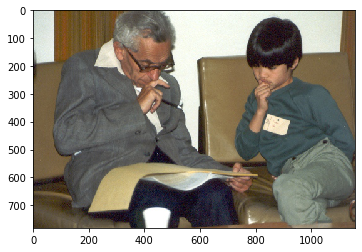

In [105]:
nn_scaled_erdos_with_tao = nn_scale_image(erdos_with_tao, 2.25)
plt.imshow(nn_scaled_erdos_with_tao)

In [121]:
def bl_scale_image(image ,s):
    shape = np.shape(image)
    nr, nc, nd = int(round(s * shape[0]) - 1), int(round(s * shape[1]) - 1), shape[2]
    output = np.zeros((nr, nc, nd), dtype="uint8")
    for x in range(nr):
        for y in range(nc):
            oldx = int(x / s)
            oldy = int(y / s)
            xf = int(np.floor(oldx))
            xc = int(np.ceil(oldy))
            yf = int(np.floor(oldy))
            yc = int(np.ceil(oldy))
            output[x][y] = (yc  - oldy) * ((xc - oldx) * image[xf][yf] + (oldx - xf) * image[xc][yf]) + (oldy - yf) * ((xc - oldx) * image[xf][yc] + (oldx - xf) * image[xc][yc])
    return output

In [122]:
bl_scaled_erdos_with_tao = bl_scale_image(erdos_with_tao, 2.25)
plt.imshow(bl_scaled_erdos_with_tao)

IndexError: index 348 is out of bounds for axis 0 with size 348